# Homework 5 - Mark Zhai

## Part 0 - Setup

In [61]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

## Part 1 - Generating and Splitting Data

In [62]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=300, factor=0.75, noise=0.3, random_state=3)

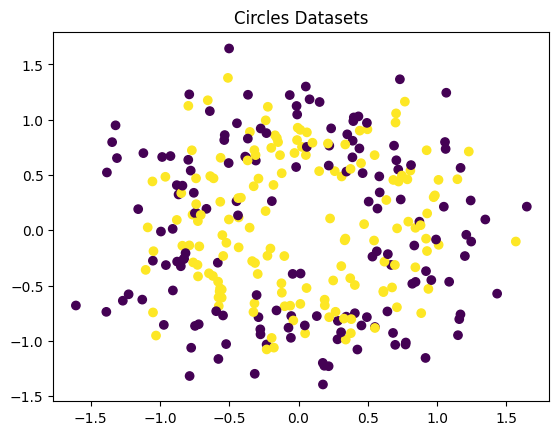

In [63]:
import matplotlib.pyplot as plt

# X[:,0] represents the X coordinates of all the points
# X[:,1] represents the Y coordinate of all the points
# y is the label for each point so we set the color to y with c=y
plt.scatter(X[:,0], X[:,1], c=y)

plt.title("Circles Datasets")

plt.show()

In [64]:
from sklearn.model_selection import train_test_split
# Split 80% training data and 20% testing data with a random_state of 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

## Part 2 - Optimizing Linear SVC + Polynomial Feature Transform

In [65]:
list_of_cs = [1E-3,1E-2,1E-1,1E0,1E1,1E2,1E3]
list_of_ds = [2,3,4]

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVC

# make pipeline that performs the polynomial feature transform, then scales, then fits with linear svc
lin_svc_pipeline = Pipeline([
    ("poly_trans", PolynomialFeatures()),
    ("scaler", StandardScaler()),
    ("lin_svc", LinearSVC(random_state=0))
])

In [67]:
from sklearn.model_selection import GridSearchCV

# define the grid to search
param_grid = {
    "poly_trans__degree" : list_of_ds,
    "lin_svc__C" : list_of_cs
}

# make a GridSearchCV object with the pipeline as the estimator, the parameter grid, and n_jobs = 1
gridsearch = GridSearchCV(lin_svc_pipeline, param_grid=param_grid, cv=4, n_jobs=1)

gridsearch.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('poly_trans', PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('lin_svc', LinearSVC(random_state=0))]),
             n_jobs=1,
             param_grid={'lin_svc__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                                        1000.0],
                         'poly_trans__degree': [2, 3, 4]})

In [68]:
print(f"Best Cross Validation Error: {1-gridsearch.best_score_}")

Best Cross Validation Error: 0.3458333333333333


In [69]:
gridsearch.best_params_

{'lin_svc__C': 0.1, 'poly_trans__degree': 2}

The best cross validation error was **0.34583** and the best parameters were **0.1** for C and a degree of **2**. This cross validation error seems high but looking at the dataset, it seems almost impossible to draw an accurate boundary between the two classes. The yellow and purple dots are too intertwined.

In [70]:
# create a pipeline with the best parameters
lin_svc_best_pipe = Pipeline([
    ("poly_trans", PolynomialFeatures(2)),
    ("scaler", StandardScaler()),
    ("lin_svc", LinearSVC(random_state=0, C=0.1))
])

In [71]:
from sklearn.metrics import accuracy_score

# train the model on the training data
lin_svc_best_pipe.fit(X_train, y_train)

# predict on the test data
y_pred = lin_svc_best_pipe.predict(X_test)

# get the test error
test_error = 1.0 - accuracy_score(y_test, y_pred)
print(f"Test Error: {test_error}")

Test Error: 0.31666666666666665


The test error of the best parameters for the linear model was **0.31667** which is slightly better than the cross validation error. Although the error is relatively high, this is expected because of the data distribution.  

## Part 3 - Polynomial-Kernel SVC

In [72]:
from sklearn.svm import SVC
# Create a pipeline with the polynomial kernel svc with the best parameters
svc_best_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="poly", degree=2, coef0=1, random_state=0, C=0.1))
])

In [73]:
from sklearn.metrics import accuracy_score

# train the model on the training data
svc_best_pipe.fit(X_train, y_train)

# predict on the test data
y_pred_svc = svc_best_pipe.predict(X_test)

# get the test error
test_error_svc = 1.0 - accuracy_score(y_test, y_pred_svc)
print(f"Test Error: {test_error_svc}")

Test Error: 0.2666666666666667


Here the test error was lower than the linear SVC + polynomial transform with a test error of **0.2667**. This suggests that using a polynomial kernel SVC will yield better results than using a linear SVC with polynomial transform.

## Part 3 - Model Comparision

In [74]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    # plt.xlabel(r"$x_1$", fontsize=20)
    # plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

In [75]:
## A useful function to visualize the decision boundary
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

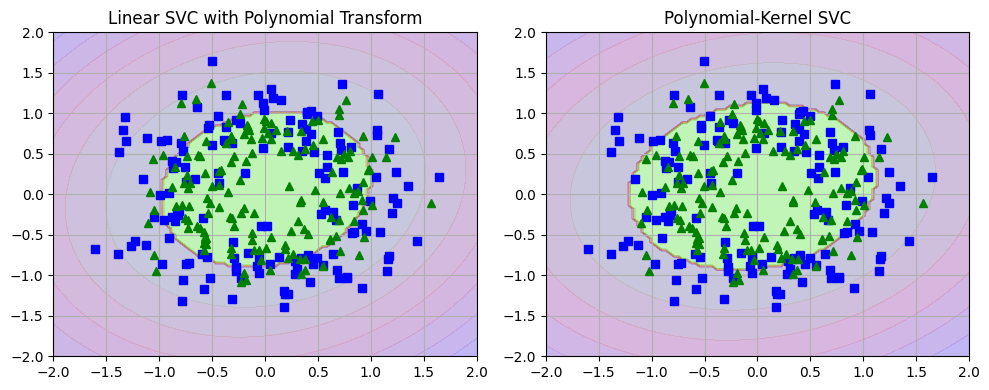

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes_limits = [-2, 2, -2, 2]

# First plot
plt.sca(axes[0])
plot_dataset(X, y, axes_limits)
plot_predictions(lin_svc_best_pipe, axes_limits)
plt.title("Linear SVC with Polynomial Transform")

# Second plot
plt.sca(axes[1])
plot_dataset(X, y, axes_limits)
plot_predictions(svc_best_pipe, axes_limits)
plt.title("Polynomial-Kernel SVC")

plt.tight_layout()
plt.show()

It appears that the polynomial-kernel SVC made a larger circle than the linear SVC with polynomial transform. It's interesting that the noise was enough to make the decision boundary more elliptical.